# Temperature, Rainfall & Vegetation
This notebook shows how to map environmental data using Google Earth Engine and make charts of trends over time.

In [1]:
import folium
import ee
import geemap
import geopandas as gpd
ee.Authenticate()

# Write your project ID here, in quotes
ee.Initialize(project = "emerge-lessons")

## Let's view the Google Earth Engine data:

First, choose a start and end date (which will be used to filter the data) and create an empty map.

In [2]:
start_date = '2025-01-01'
end_date = '2025-01-31'

We can create an empty map zoomed to Florida using just these two lines of code:

In [3]:
map = folium.Map(location=[28.263363, -83.497652], tiles="Cartodb dark_matter", zoom_start=7)
display(map)

Next, we define a function (from [this tutorial](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api)) to add Google Earth Engine data to a map in a way that allows it to be interactively displayed.

In [4]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

We'll also load the boundary of Florida, which we will use to crop the data to focus on Florida.

In [5]:
fl = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/florida_boundary.geojson')[['geometry']]
region = geemap.geopandas_to_ee(fl)

### Land Surface Temperature (LST)
[MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global 1km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1)

From this dataset, we will use LST_Day_1km: Daytime Land Surface Temperature, which is measured in Kelvin.

In [6]:
lst = (
    ee.ImageCollection('MODIS/061/MOD11A1')
      .filterDate(start_date, end_date)
      .select('LST_Day_1km')
      .median()
      .clip(region)
)

lst_vis = {
    'min': 13000.0,
    'max': 16500.0,
    'palette': [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ],
}

map.add_ee_layer(lst, lst_vis, "LST")

display(map)

### Satellite Image
[Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR)](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED)

In [7]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.
  Args:
      image (ee.Image): A Sentinel-2 image.
  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [8]:
rgb = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterDate(start_date, end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
      .map(mask_s2_clouds)
      .median()
      .clip(region)
)

rgb_vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

map.add_ee_layer(rgb, rgb_vis, 'Sentinel-2 RGB')
display(map)

This may take a minute to load. You may notice "gaps" between the satellite images. This is because the satellite layer is made up of multiple, separate satellite images pieced together (into a mosaic). The images that were marked as more than 20% cloudy have been filtered out.

### Normalized Difference Vegetation Index (NDVI)
We can use the Sentinel-2 satellite image to calculate the Normalized Difference Vegetation Index (NDVI), which is a value from -1 to 1 representing vegetation levels. NDVI is calculated based on the bands of the satellite image:
$NDVI = \frac{NIR - Red}{NIR + Red}$

In [9]:
ndvi = rgb.normalizedDifference(['B8', 'B4']).rename('NDVI')

In Sentinel-2, there are 12 bands. Band 8 is NIR and Band 4 is Red. Above, the `.normalizedDifference` function calculates $NDVI = \frac{B8 - B4}{B8 + B4}$

In [10]:
ndvi_vis = {
  'min': -1,
  'max': 1,
  'palette': ['blue', 'white', 'green']
}

map.add_ee_layer(ndvi, ndvi_vis, 'NDVI')
display(map)

### Normalized Difference Water Index (NDWI)

The Normalized Difference Water Index (NDWI) measures water content. It is calculated as $NDWI = \frac{B3 - B8}{B3 + B8}$

In [11]:
ndwi = rgb.normalizedDifference(['B3', 'B8']).rename('NDWI')

ndwi_vis = {
  'min': -1,
  'max': 1,
  'palette': ['white', 'blue']
}

map.add_ee_layer(ndwi, ndwi_vis, 'NDWI')
display(map)

### Precipitation
[CHIRPS Daily: Climate Hazards Center InfraRed Precipitation With Station Data (Version 2.0 Final)](https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY)

In [12]:
rain = (
    ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
      .filterDate(start_date, end_date)
      .select('precipitation')
      .sum()
      .clip(region)
)

rain_vis = {
    'min': 0,
    'max': 100,
    'palette': ['white', 'blue'],
}

map.add_ee_layer(rain, rain_vis, 'Precipitation')

display(map)

### Final Map

By using `folium.LayerControl`, we can add the option to select which data on the map we want to see. In the interactive map below, you can click on the menu in the upper right to select which layers.

Note that the layer on the bottom is viewed first, so if all the layers are checked, then "Precipitation" will be displayed as the top layer on the map.

In [13]:
folium.LayerControl(collapsed = False).add_to(map)
display(map)

## Data Over Time

In [14]:
import pandas as pd
pd.set_option("display.max_columns", None)
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pylab import *

mosquito = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/globe_mosquito.zip')

In [15]:
# Define a set of coordinates in Florida
longitude = -80.57107
latitude = 25.48361

# Get all satellite images (past & recent) near that point
coords = [longitude, latitude]
point = ee.Geometry.Point(coords)
sentinel2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .map(mask_s2_clouds)
    .getRegion(point, 500)
    .getInfo()
)

In [16]:
# Create a table
sentinel2 = pd.DataFrame(sentinel2[1:], columns = sentinel2[0])
sentinel2.head()

,id,longitude,latitude,time,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AOT,WVP,SCL,TCI_R,TCI_G,TCI_B,MSK_CLDPRB,MSK_SNWPRB,QA10,QA20,QA60,MSK_CLASSI_OPAQUE,MSK_CLASSI_CIRRUS,MSK_CLASSI_SNOW_ICE
0,20180312T160511_20180312T160507_T17RNJ,-80.572144,25.482959,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20180401T160511_20180401T160510_T17RNJ,-80.572144,25.482959,None,0.0960,0.1083,0.1184,0.1235,0.1482,0.1652,0.1739,0.1828,0.1864,0.1862,0.1874,0.1389,0.0150,0.2647,0.0007,0.0126,0.0121,0.0111,0.0008,0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,20181217T160501_20181217T160503_T17RNJ,-80.572144,25.482959,None,0.0321,0.0428,0.0750,0.0825,0.1308,0.1685,0.1899,0.2037,0.2126,0.2276,0.1646,0.1044,0.0138,0.1686,0.0004,0.0084,0.0077,0.0045,0.0003,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,20181222T160509_20181222T160507_T17RNJ,-80.572144,25.482959,None,0.0273,0.0486,0.0745,0.0830,0.1219,0.1449,0.1639,0.1815,0.1839,0.2036,0.1544,0.1053,0.0150,0.1330,0.0007,0.0084,0.0076,0.0050,0.0003,0.0,0.0,0.0,0.0,NaN,NaN,NaN
4,20181227T160501_20181227T160504_T17RNJ,-80.572144,25.482959,None,0.3348,0.3491,0.3418,0.3229,0.3618,0.3701,0.3764,0.3790,0.3884,0.6789,0.2924,0.2438,0.0204,0.2710,0.0008,0.0243,0.0247,0.0248,0.0078,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [17]:
# Calculate NDVI and NDWI
sentinel2['time'] = pd.to_datetime(sentinel2['id'].str[0:15], format = "%Y%m%dT%H%M%S")
sentinel2['NDVI'] = (sentinel2['B8'] - sentinel2['B4']) / (sentinel2['B8'] + sentinel2['B4'])
sentinel2['NDWI'] = (sentinel2['B3'] - sentinel2['B8']) / (sentinel2['B3'] + sentinel2['B8'])

# Interpolate to replace any missing values
sentinel2['NDVI'] = sentinel2['NDVI'].interpolate()

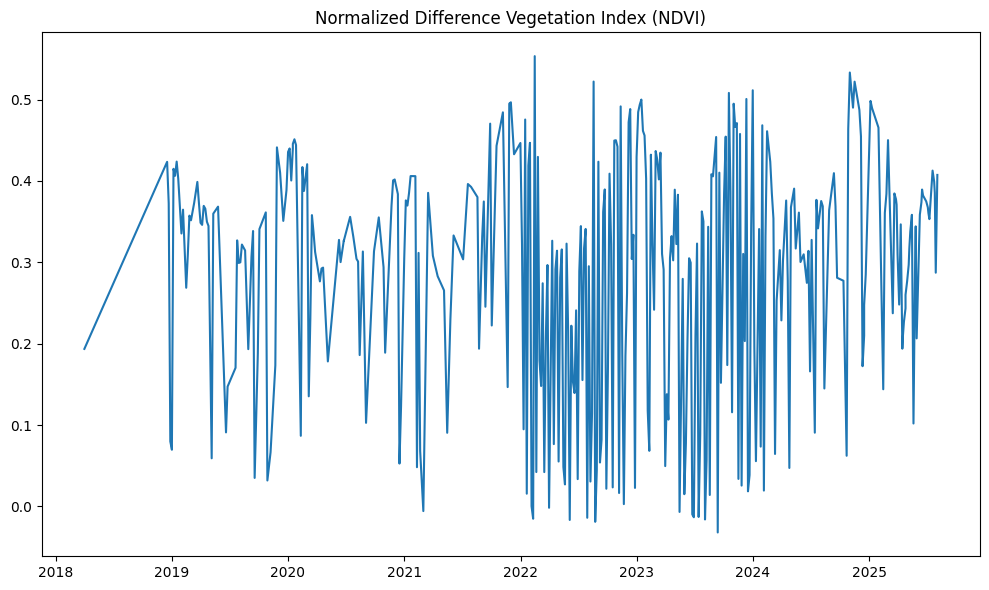

In [18]:
# Create plot of NDVI over time
plt.figure(figsize = (10, 6))
plt.plot(sentinel2['time'], sentinel2['NDVI'])
plt.title("Normalized Difference Vegetation Index (NDVI)")
plt.tight_layout()
plt.show()

We can see that, each year, the NDVI changes with the seasons as it fluctuates up and down. So, it may be helpful to plot this in a slightly different way, showing NDVI each month instead of one line showing multiple years.

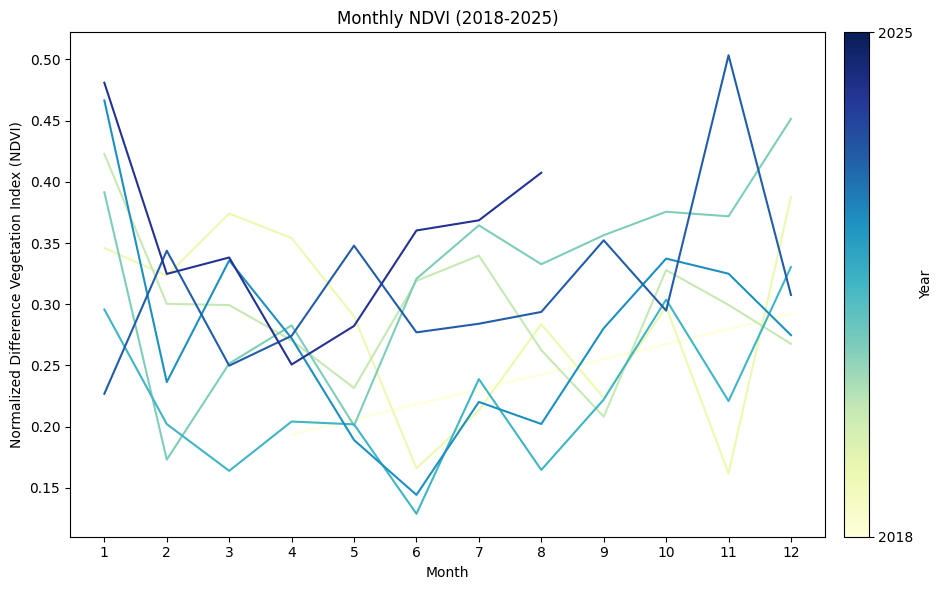

In [19]:
# Add year and month columns
sentinel2['year'] = sentinel2['time'].dt.year
sentinel2['month'] = sentinel2['time'].dt.month
# Get unique years
years = sorted(sentinel2['year'].unique())

# Set up the plot
fig, ax = plt.subplots(figsize = (10, 6))

# Plot one line per year with different colors
cmap = plt.get_cmap('YlGnBu')
colors = [cmap(i / len(years)) for i in range(len(years))]
for i, year in enumerate(years):
    year_data = sentinel2[sentinel2['year'] == year]
    monthly_avg = year_data.groupby('month')['NDVI'].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=str(year), color=colors[i])

# Add colorbar
sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=min(years), vmax=max(years)))
sm.set_array([])  # Dummy array for the ScalarMappable
cbar = plt.colorbar(sm, orientation='vertical', pad=0.02, ax=ax)
cbar.set_label('Year')
cbar.set_ticks([min(years), max(years)])
cbar.set_ticklabels([str(min(years)), str(max(years))])

# Customize the chart
plt.title('Monthly NDVI (2018-2025)')
plt.xlabel('Month')
plt.ylabel('Normalized Difference Vegetation Index (NDVI)')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

In [20]:
# Create a function to do this for a given dataset
def plot_over_time(longitude, latitude, name):
  coords = [longitude, latitude]
  point = ee.Geometry.Point(coords)
  if (name == 'NDVI') or (name == 'NDWI'):
    image = (
      ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .map(mask_s2_clouds)
      .getRegion(point, scale=10)
      .getInfo()
    )
    # Create table
    image = pd.DataFrame(image[1:], columns = image[0])
    image[['B8', 'B4', 'B3']] = image[['B8', 'B4', 'B3']].interpolate()
    image['time'] = pd.to_datetime(image['id'].str[0:15], format = "%Y%m%dT%H%M%S")
    image['NDVI'] = (image['B8'] - image['B4']) / (image['B8'] + image['B4'])
    image['NDWI'] = (image['B3'] - image['B8']) / (image['B3'] + image['B8'])
    ylabel = name

  elif name == 'LST':
    image = (
        ee.ImageCollection('MODIS/061/MOD11A1')
          .getRegion(point, scale=1000)
          .getInfo()
    )
    # Create table
    image = pd.DataFrame(image[1:], columns = image[0])
    image['time'] = pd.to_datetime(image['id'], format = "%Y_%m_%d")
    # Convert Kelvin to Fahrenheit
    scale_value = 0.02        # The data has a scale factor we need to account for
    image['LST'] = (image['LST_Day_1km'].interpolate() * scale_value - 273.15) * 1.8 + 32
    ylabel = "LST (Fahrenheit)"

  elif name == 'Precipitation':
    image = (
        ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
          .select('precipitation')
          .getRegion(point, scale=5566)
          .getInfo()
    )
    # Create table
    image = pd.DataFrame(image[1:], columns = image[0])
    image['time'] = pd.to_datetime(image['id'], format = "%Y%m%d")
    image['Precipitation'] = image['precipitation'].interpolate()
    ylabel = "Precipitation (mm/day)"

  # Add year and month columns
  image['year'] = image['time'].dt.year
  image['month'] = image['time'].dt.month
  # Get unique years
  years = sorted(image['year'].unique())

  ## Create plots
  fig, (ax1, ax2) = plt.subplots(2, figsize = (10, 8))
  ax1.plot(image['time'], image[name])
  ax1.set_title(name)
  ax1.set_ylabel(ylabel)

  # Plot one line per year with different colors
  cmap = plt.get_cmap('YlGnBu')
  colors = [cmap(i / len(years)) for i in range(len(years))]
  for i, year in enumerate(years):
      year_data = image[image['year'] == year]
      monthly_avg = year_data.groupby('month')[name].mean()
      ax2.plot(monthly_avg.index, monthly_avg.values, label=str(year), color=colors[i])

  # Add colorbar
  sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=min(years), vmax=max(years)))
  sm.set_array([])
  cbar = fig.colorbar(sm, orientation='vertical', pad=0.02, ax=ax2)
  cbar.set_label('Year')
  cbar.set_ticks([min(years), max(years)])
  cbar.set_ticklabels([str(min(years)), str(max(years))])

  # Customize the chart
  ax2.set_title(f'Monthly {name} ({min(years)}-{max(years)})')
  ax2.set_xlabel('Month')
  ax2.set_ylabel(ylabel)
  ax2.set_xticks(range(1, 13))

  plt.tight_layout()
  plt.show()

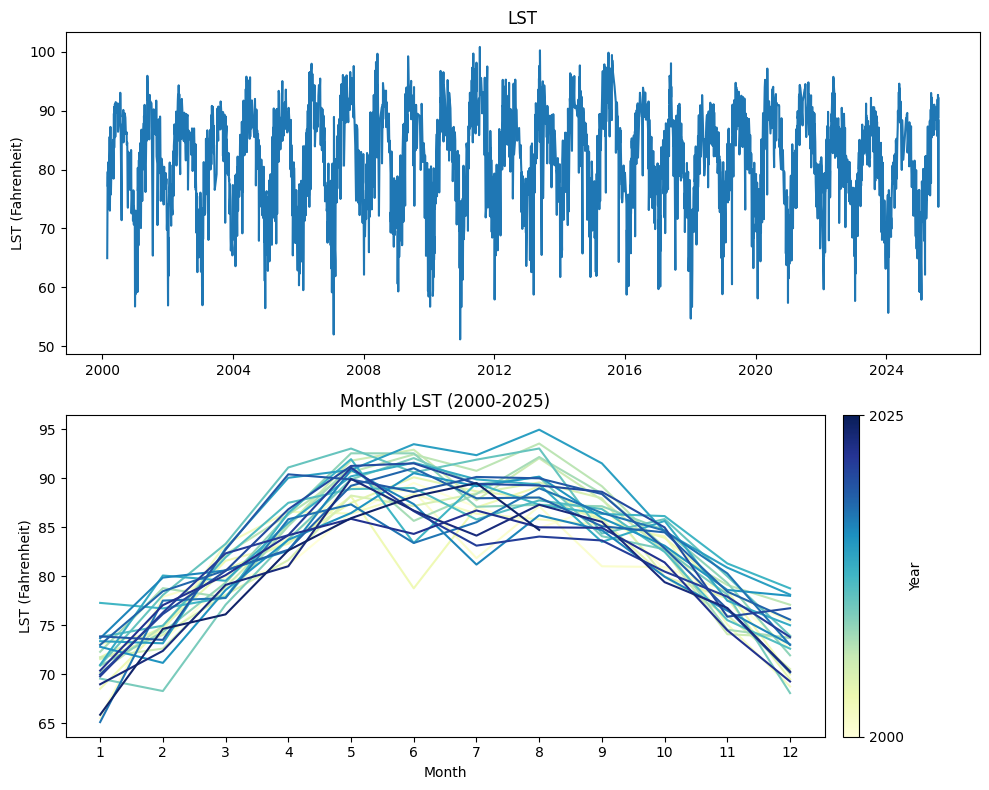

In [21]:
plot_over_time(-80.469649, 26.030573, 'LST')

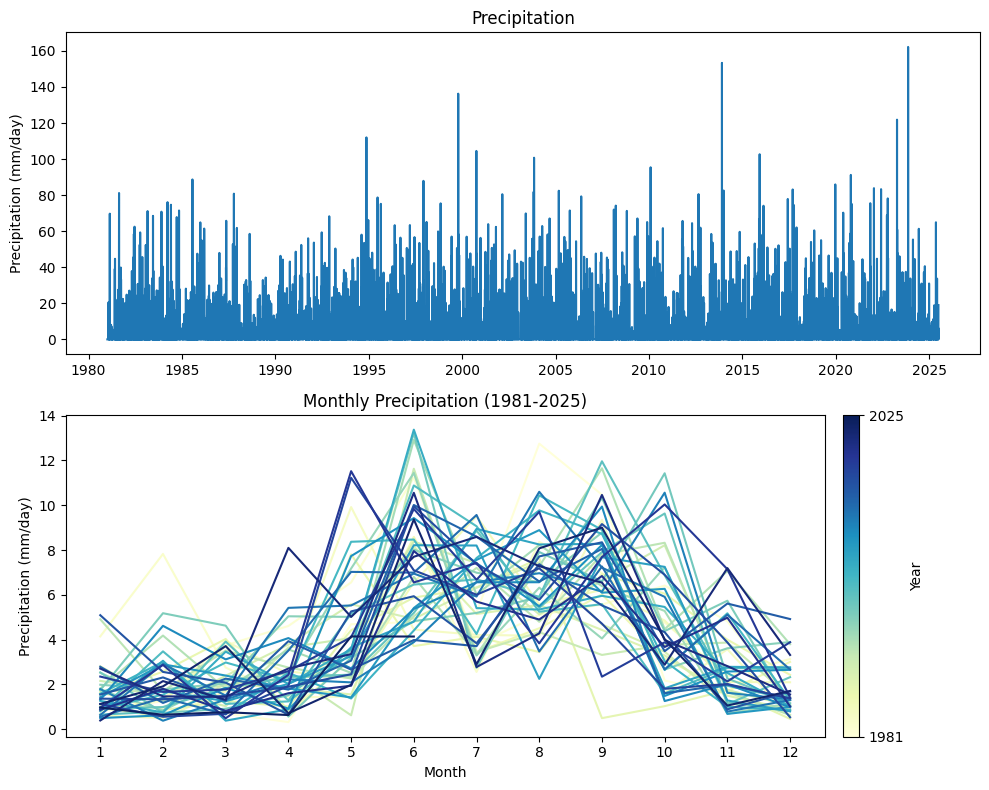

In [22]:
plot_over_time(-80.469649, 26.030573, 'Precipitation')

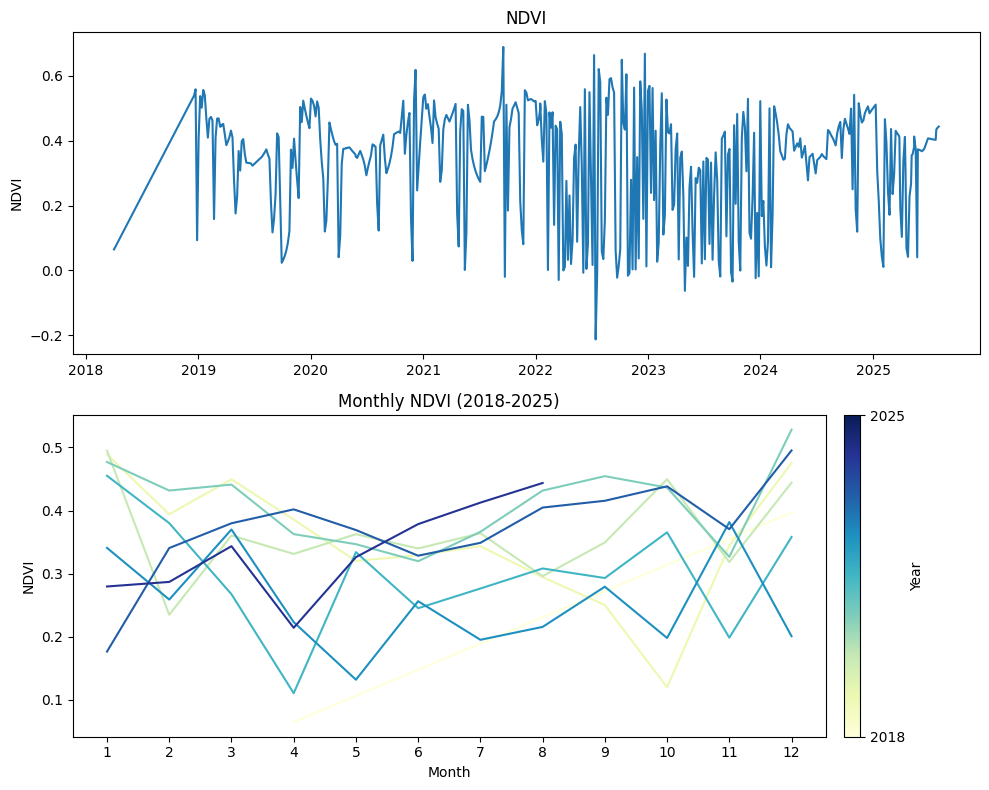

In [23]:
plot_over_time(-80.469649, 26.030573, 'NDVI')

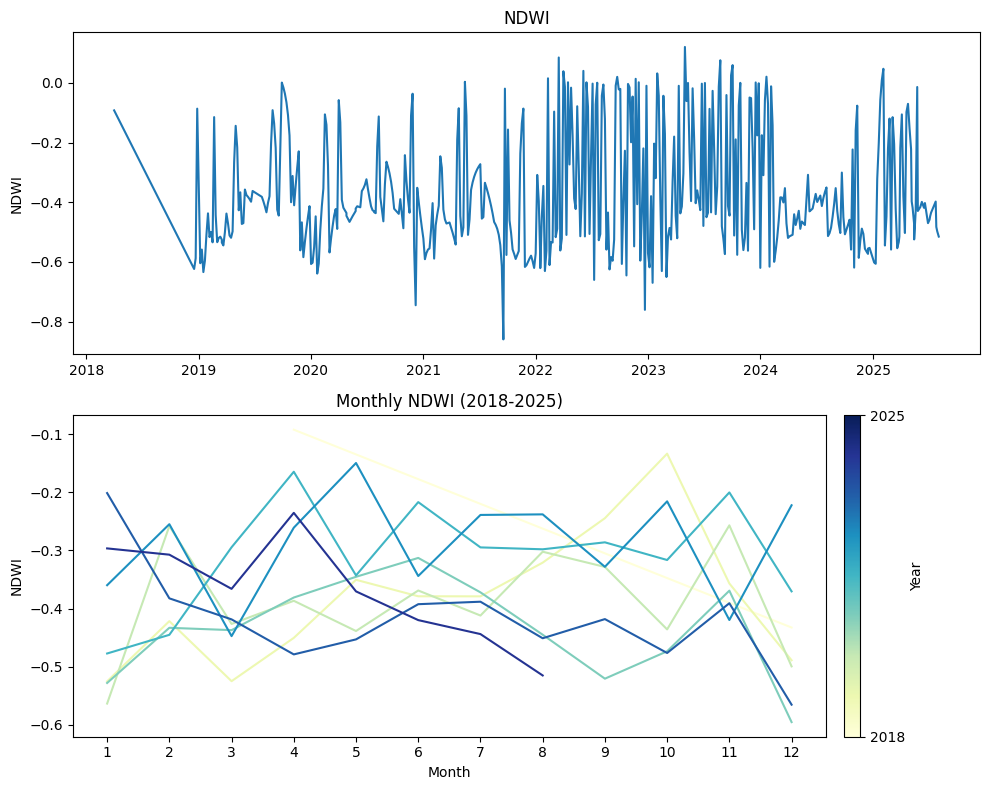

In [24]:
plot_over_time(-80.469649, 26.030573, 'NDWI')

References
- Code: [Display Proba-V NDVI (Normalized Difference Vegetation Index) Time-Series](https://github.com/renelikestacos/Google-Earth-Engine-Python-Examples/blob/master/004_EE_Retrieve_Proba-V_NDVI_Time-Series.ipynb)
- Data: [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR)](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED)